## 1.5 实践：基于前馈神经网络完成鸢尾花分类

本实践中使用鸢尾花分类任务，分类器为前馈神经网络；损失函数为交叉熵损失；优化器为随机梯度下降法；评价指标为准确率。

### 1.5.1 小批量梯度下降法
在梯度下降法中，目标函数是整个训练集上的风险函数，这种方式称为**批量梯度下降法（Batch Gradient Descent，BGD）**。 批量梯度下降法在每次迭代时需要计算每个样本上损失函数的梯度并求和。当训练集中的样本数量$N$很大时，空间复杂度比较高，每次迭代的计算开销也很大。

为了减少每次迭代的计算复杂度，我们可以在每次迭代时只采集一小部分样本，计算在这组样本上损失函数的梯度并更新参数，这种优化方式称为
小批量梯度下降法（Mini-Batch Gradient Descent，Mini-Batch GD）。

第$t$次迭代时，随机选取一个包含$K$个样本的子集$\mathcal{B}_t$，计算这个子集上每个样本损失函数的梯度并进行平均，然后再进行参数更新。
$$
\theta_{t+1} \leftarrow \theta_t  - \alpha \frac{1}{K} \sum_{(\boldsymbol{x},y)\in \mathcal{S}_t} \frac{\partial \mathcal{L}\Big(y,f(\boldsymbol{x};\theta)\Big)}{\partial \theta},
$$
其中$K$为**批量大小(Batch Size)**。$K$通常不会设置很大，一般在$1\sim100$之间。在实际应用中为了提高计算效率，通常设置为2的幂$2^n$。

在实际应用中，小批量随机梯度下降法有收敛快、计算开销小的优点，因此逐渐成为大规模的机器学习中的主要优化算法。
此外，随机梯度下降相当于在批量梯度下降的梯度上引入了随机噪声。在非凸优化问题中，随机梯度下降更容易逃离局部最优点。

小批量随机梯度下降法的训练过程如下：

![](https://ai-studio-static-online.cdn.bcebos.com/49287f7b41234d718fcc79b3f8edc64f366b05f460fb49cea88805777d508d82)


#### 4.5.1.1 数据分组
为了小批量梯度下降法，我们需要对数据进行随机分组。目前，机器学习中通常做法是构建一个**数据迭代器**，每个迭代过程中从全部数据集中获取一批指定数量的数据。

数据迭代器的实现原理如下图所示：

![](https://ai-studio-static-online.cdn.bcebos.com/337735d2bf6c49dda5415d791f6a320ffe739a809b3541faa26bfb8331506cb3)


1. 首先，将数据集封装为Dataset类，传入一组索引值，根据索引从数据集合中获取数据；
1. 其次，构建DataLoader类，需要指定数据批量的大小和是否需要对数据进行乱序，通过该类即可批量获取数据。

在实践过程中，通常使用进行参数优化。在飞桨中，使用`paddle.io.DataLoader`加载minibatch的数据，
`paddle.io.DataLoader`  API可以生成一个迭代器，其中通过设置`batch_size`参数来指定minibatch的长度，通过设置shuffle参数为True，可以在生成`minibatch`的索引列表时将索引顺序打乱。

### 1.5.2 数据处理

构造IrisDataset类进行数据读取，继承自`paddle.io.Dataset`类。`paddle.io.Dataset`是用来封装 Dataset的方法和行为的抽象类，通过一个索引获取指定的样本，同时对该样本进行数据处理。当继承`paddle.io.Dataset`来定义数据读取类时，实现如下方法：

* `__getitem__`：根据给定索引获取数据集中指定样本，并对样本进行数据处理；
* `__len__`：返回数据集样本个数。

代码实现如下：

In [1]:
import numpy as np
import paddle
import paddle.io as io
from nndl.dataset import load_data

class IrisDataset(io.Dataset):
    def __init__(self, mode='train', num_train=120, num_dev=15):
        super(IrisDataset, self).__init__()
        # 调用第三章中的数据读取函数，其中不需要将标签转成one-hot类型
        X, y = load_data(shuffle=True)
        if mode == 'train':
            self.X, self.y = X[:num_train], y[:num_train]
        elif mode == 'dev':
            self.X, self.y = X[num_train:num_train + num_dev], y[num_train:num_train + num_dev]
        else:
            self.X, self.y = X[num_train + num_dev:], y[num_train + num_dev:]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return len(self.y)

In [2]:
paddle.seed(12)
train_dataset = IrisDataset(mode='train')
dev_dataset = IrisDataset(mode='dev')
test_dataset = IrisDataset(mode='test')

/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/fluid/variable_index.py:292: UserWarning: 1-D Tensor will be treat as advanced indexing in future version. Currently, 1-D Tensor means a scalar, not vector, and please modify it to 0-D Tensor. If advanced indexing is needed, please use `export FLAGS_set_to_1d=False` to set the flag.
  warnings.warn(
/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/fluid/variable_index.py:591: UserWarning: Warning: In Tensor '__getitem__', if the number of scalar elements in the index is equal to the rank of the Tensor, the output should be 0-D. In order to be consistent with the behavior of previous versions, it will be processed to 1-D. But it is not correct and will be removed in release 2.6. If 1-D is still wanted, please modify the index element from scalar to slice (e.g. 'x[i]' => 'x[i:i+1]').
  warnings.warn(


In [3]:
# 打印训练集长度
print ("length of train set: ", len(train_dataset))

length of train set:  120


#### 1.5.2.2 用DataLoader进行封装

In [4]:
# 批量大小
batch_size = 16

# 加载数据
train_loader = io.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = io.DataLoader(dev_dataset, batch_size=batch_size)
test_loader = io.DataLoader(test_dataset, batch_size=batch_size)

### 1.5.3 模型构建

构建一个简单的前馈神经网络进行鸢尾花分类实验。其中输入层神经元个数为4，输出层神经元个数为3，隐含层神经元个数为6。代码实现如下：

In [5]:
from paddle import nn

# 定义前馈神经网络
class Model_MLP_L2_V3(nn.Layer):
    def __init__(self, input_size, output_size, hidden_size):
        super(Model_MLP_L2_V3, self).__init__()
        # 构建第一个全连接层
        self.fc1 = nn.Linear(
            input_size,
            hidden_size,
            weight_attr=paddle.ParamAttr(initializer=nn.initializer.Normal(mean=0.0, std=0.01)),
            bias_attr=paddle.ParamAttr(initializer=nn.initializer.Constant(value=1.0))
        )
        # 构建第二全连接层
        self.fc2 = nn.Linear(
            hidden_size,
            output_size,
            weight_attr=paddle.ParamAttr(initializer=nn.initializer.Normal(mean=0.0, std=0.01)),
            bias_attr=paddle.ParamAttr(initializer=nn.initializer.Constant(value=1.0))
        )
        # 定义网络使用的激活函数
        self.act = nn.Sigmoid()

    def forward(self, inputs):
        outputs = self.fc1(inputs)
        outputs = self.act(outputs)
        outputs = self.fc2(outputs)
        return outputs

fnn_model = Model_MLP_L2_V3(input_size=4, output_size=3, hidden_size=6)

### 1.5.4 完善Runner类

基于一个基础的网络RunnerV2进行完善实现了RunnerV3类。其中训练过程使用自动梯度计算，使用`DataLoader`加载批量数据，使用随机梯度下降法进行参数优化；模型保存时，使用`state_dict`方法获取模型参数；模型加载时，使用`set_state_dict`方法加载模型参数.

由于这里使用随机梯度下降法对参数优化，所以数据以批次的形式输入到模型中进行训练，那么评价指标计算也是分别在每个批次进行的，要想获得每个epoch整体的评价结果，需要对历史评价结果进行累积。这里定义`Accuracy`类实现该功能。

In [6]:
from paddle.metric import Metric

class Accuracy(Metric):
    def __init__(self, is_logist=True):
        """
        输入：
           - is_logist: outputs是logist还是激活后的值
        """

        # 用于统计正确的样本个数
        self.num_correct = 0
        # 用于统计样本的总数
        self.num_count = 0

        self.is_logist = is_logist

    def update(self, outputs, labels):
        """
        输入：
           - outputs: 预测值, shape=[N,class_num]
           - labels: 标签值, shape=[N,1]
        """

        # 判断是二分类任务还是多分类任务，shape[1]=1时为二分类任务，shape[1]>1时为多分类任务
        if outputs.shape[1] == 1: # 二分类
            outputs = paddle.squeeze(outputs, axis=-1)
            if self.is_logist:
                # logist判断是否大于0
                preds = paddle.cast((outputs>=0), dtype='float32')
            else:
                # 如果不是logist，判断每个概率值是否大于0.5，当大于0.5时，类别为1，否则类别为0
                preds = paddle.cast((outputs>=0.5), dtype='float32')
        else:
            # 多分类时，使用'paddle.argmax'计算最大元素索引作为类别
            preds = paddle.argmax(outputs, axis=1, dtype='int64')

        # 获取本批数据中预测正确的样本个数
        labels = paddle.squeeze(labels, axis=-1)
        batch_correct = paddle.sum(paddle.cast(preds==labels, dtype="float32")).numpy()[0]
        batch_count = len(labels)

        # 更新num_correct 和 num_count
        self.num_correct += batch_correct
        self.num_count += batch_count

    def accumulate(self):
        # 使用累计的数据，计算总的指标
        if self.num_count == 0:
            return 0
        return self.num_correct / self.num_count

    def reset(self):
        # 重置正确的数目和总数
        self.num_correct = 0
        self.num_count = 0

    def name(self):
        return "Accuracy"


RunnerV3类的代码实现如下：

In [7]:
import paddle.nn.functional as F

class RunnerV3(object):
    def __init__(self, model, optimizer, loss_fn, metric, **kwargs):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.metric = metric # 只用于计算评价指标

        # 记录训练过程中的评价指标变化情况
        self.dev_scores = []

        # 记录训练过程中的损失函数变化情况
        self.train_epoch_losses = [] # 一个epoch记录一次loss
        self.train_step_losses = []  # 一个step记录一次loss
        self.dev_losses = []
        
        # 记录全局最优指标
        self.best_score = 0

    def train(self, train_loader, dev_loader=None, **kwargs):
        # 将模型切换为训练模式
        self.model.train()

        # 传入训练轮数，如果没有传入值则默认为0
        num_epochs = kwargs.get("num_epochs", 0)
        # 传入log打印频率，如果没有传入值则默认为100
        log_steps = kwargs.get("log_steps", 100)
        # 评价频率
        eval_steps = kwargs.get("eval_steps", 0)

        # 传入模型保存路径，如果没有传入值则默认为"best_model.pdparams"
        save_path = kwargs.get("save_path", "best_model.pdparams")

        custom_print_log = kwargs.get("custom_print_log", None) 
       
        # 训练总的步数
        num_training_steps = num_epochs * len(train_loader)

        if eval_steps:
            if self.metric is None:
                raise RuntimeError('Error: Metric can not be None!')
            if dev_loader is None:
                raise RuntimeError('Error: dev_loader can not be None!')
            
        # 运行的step数目
        global_step = 0

        # 进行num_epochs轮训练
        for epoch in range(num_epochs):
            # 用于统计训练集的损失
            total_loss = 0
            for step, data in enumerate(train_loader):
                X, y = data
                # 获取模型预测
                logits = self.model(X)
                loss = self.loss_fn(logits, y) # 默认求mean
                total_loss += loss 

                # 训练过程中，每个step的loss进行保存
                self.train_step_losses.append((global_step,loss.item()))

                if log_steps and global_step%log_steps==0:
                    print(f"[Train] epoch: {epoch}/{num_epochs}, step: {global_step}/{num_training_steps}, loss: {loss.item():.5f}")
                
                # 梯度反向传播，计算每个参数的梯度值
                loss.backward() 

                if custom_print_log:
                   custom_print_log(self)
                
                # 小批量梯度下降进行参数更新
                self.optimizer.step()
                # 梯度归零
                self.optimizer.clear_grad()

                # 判断是否需要评价
                if eval_steps>0 and global_step>0 and \
                    (global_step%eval_steps == 0 or global_step==(num_training_steps-1)):

                    dev_score, dev_loss = self.evaluate(dev_loader, global_step=global_step)
                    print(f"[Evaluate]  dev score: {dev_score:.5f}, dev loss: {dev_loss:.5f}") 

                    # 将模型切换为训练模式
                    self.model.train()

                    # 如果当前指标为最优指标，保存该模型
                    if dev_score > self.best_score:
                        self.save_model(save_path)
                        print(f"[Evaluate] best accuracy performence has been updated: {self.best_score:.5f} --> {dev_score:.5f}")
                        self.best_score = dev_score

                global_step += 1
            
            # 当前epoch 训练loss累计值 
            trn_loss = (total_loss / len(train_loader)).item()
            # epoch粒度的训练loss保存
            self.train_epoch_losses.append(trn_loss)
            
        print("[Train] Training done!")

    # 模型评估阶段，使用'paddle.no_grad()'控制不计算和存储梯度
    @paddle.no_grad()
    def evaluate(self, dev_loader, **kwargs):
        assert self.metric is not None

        # 将模型设置为评估模式
        self.model.eval()

        global_step = kwargs.get("global_step", -1) 

        # 用于统计训练集的损失
        total_loss = 0

        # 重置评价
        self.metric.reset() 
        
        # 遍历验证集每个批次    
        for batch_id, data in enumerate(dev_loader):
            X, y = data
    
            # 计算模型输出
            logits = self.model(X)
            
            # 计算损失函数
            loss = self.loss_fn(logits, y).item()
            # 累积损失
            total_loss += loss 

            # 累积评价
            self.metric.update(logits, y)

        dev_loss = (total_loss/len(dev_loader))
        dev_score = self.metric.accumulate() 

        # 记录验证集loss
        if global_step!=-1:
            self.dev_losses.append((global_step, dev_loss))
            self.dev_scores.append(dev_score)
        
        return dev_score, dev_loss
    
    # 模型评估阶段，使用'paddle.no_grad()'控制不计算和存储梯度
    @paddle.no_grad()
    def predict(self, x, **kwargs):
        # 将模型设置为评估模式
        self.model.eval()
        # 运行模型前向计算，得到预测值
        logits = self.model(x)
        return logits

    def save_model(self, save_path):
        paddle.save(self.model.state_dict(), save_path)

    def load_model(self, model_path):
        model_state_dict = paddle.load(model_path)
        self.model.set_state_dict(model_state_dict)

### 1.5.5 模型训练

实例化RunnerV3类，并传入训练配置，代码实现如下：

In [8]:
import paddle.optimizer as opt

lr = 0.2

# 定义网络
model = fnn_model

# 定义优化器
optimizer = opt.SGD(learning_rate=lr, parameters=model.parameters())

# 定义损失函数。softmax+交叉熵
loss_fn = F.cross_entropy

# 定义评价指标
metric = Accuracy(is_logist=True)

runner = RunnerV3(model, optimizer, loss_fn, metric)

使用训练集和验证集进行模型训练，共训练150个epoch。在实验中，保存准确率最高的模型作为最佳模型。代码实现如下：

In [9]:
# 启动训练
log_steps = 100
eval_steps = 50
runner.train(train_loader, dev_loader, 
            num_epochs=150, log_steps=log_steps, eval_steps = eval_steps,
            save_path="best_model.pdparams") 

[Train] epoch: 0/150, step: 0/1200, loss: 1.09862
[Evaluate]  dev score: 0.40000, dev loss: 1.09698
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.40000
[Train] epoch: 12/150, step: 100/1200, loss: 1.14937
[Evaluate]  dev score: 0.40000, dev loss: 1.09135


I1226 16:17:01.434818  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:17:01.529585  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:17:01.624795  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will 

[Evaluate]  dev score: 0.40000, dev loss: 1.08838
[Train] epoch: 25/150, step: 200/1200, loss: 1.09891
[Evaluate]  dev score: 0.40000, dev loss: 1.08594
[Evaluate]  dev score: 0.40000, dev loss: 1.09131


I1226 16:17:01.713804  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:17:01.800307  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:17:01.888845  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will 

[Train] epoch: 37/150, step: 300/1200, loss: 1.00115
[Evaluate]  dev score: 0.40000, dev loss: 1.09148
[Evaluate]  dev score: 0.40000, dev loss: 1.03086
[Train] epoch: 50/150, step: 400/1200, loss: 0.94129
[Evaluate]  dev score: 0.46667, dev loss: 0.92721
[Evaluate] best accuracy performence has been updated: 0.40000 --> 0.46667


I1226 16:17:01.979004  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:17:02.070436  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:17:02.162946  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will 

[Evaluate]  dev score: 0.80000, dev loss: 0.77776
[Evaluate] best accuracy performence has been updated: 0.46667 --> 0.80000
[Train] epoch: 62/150, step: 500/1200, loss: 0.70199
[Evaluate]  dev score: 0.80000, dev loss: 0.63983
[Evaluate]  dev score: 0.93333, dev loss: 0.54415
[Evaluate] best accuracy performence has been updated: 0.80000 --> 0.93333


I1226 16:17:02.258417  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:17:02.345458  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:17:02.439519  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will 

[Train] epoch: 75/150, step: 600/1200, loss: 0.43442
[Evaluate]  dev score: 0.86667, dev loss: 0.48540
[Evaluate]  dev score: 0.93333, dev loss: 0.43963
[Train] epoch: 87/150, step: 700/1200, loss: 0.49862
[Evaluate]  dev score: 1.00000, dev loss: 0.40922
[Evaluate] best accuracy performence has been updated: 0.93333 --> 1.00000


I1226 16:17:02.531461  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:17:02.620134  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:17:02.708503  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will 

[Evaluate]  dev score: 1.00000, dev loss: 0.38428
[Train] epoch: 100/150, step: 800/1200, loss: 0.29653
[Evaluate]  dev score: 0.80000, dev loss: 0.37453
[Evaluate]  dev score: 0.93333, dev loss: 0.33972


I1226 16:17:02.803179  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:17:02.892277  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:17:02.983263  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will 

[Train] epoch: 112/150, step: 900/1200, loss: 0.35408
[Evaluate]  dev score: 1.00000, dev loss: 0.32045
[Evaluate]  dev score: 1.00000, dev loss: 0.30739
[Train] epoch: 125/150, step: 1000/1200, loss: 0.30250
[Evaluate]  dev score: 0.93333, dev loss: 0.28491


I1226 16:17:03.072230  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:17:03.174403  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:17:03.270982  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will 

[Evaluate]  dev score: 1.00000, dev loss: 0.27021
[Train] epoch: 137/150, step: 1100/1200, loss: 0.21231
[Evaluate]  dev score: 1.00000, dev loss: 0.25880
[Evaluate]  dev score: 0.93333, dev loss: 0.24206
[Evaluate]  dev score: 1.00000, dev loss: 0.23440
[Train] Training done!


I1226 16:17:03.360915  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:17:03.450371  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:17:03.541106  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will 

可视化观察训练集损失和训练集loss变化情况。

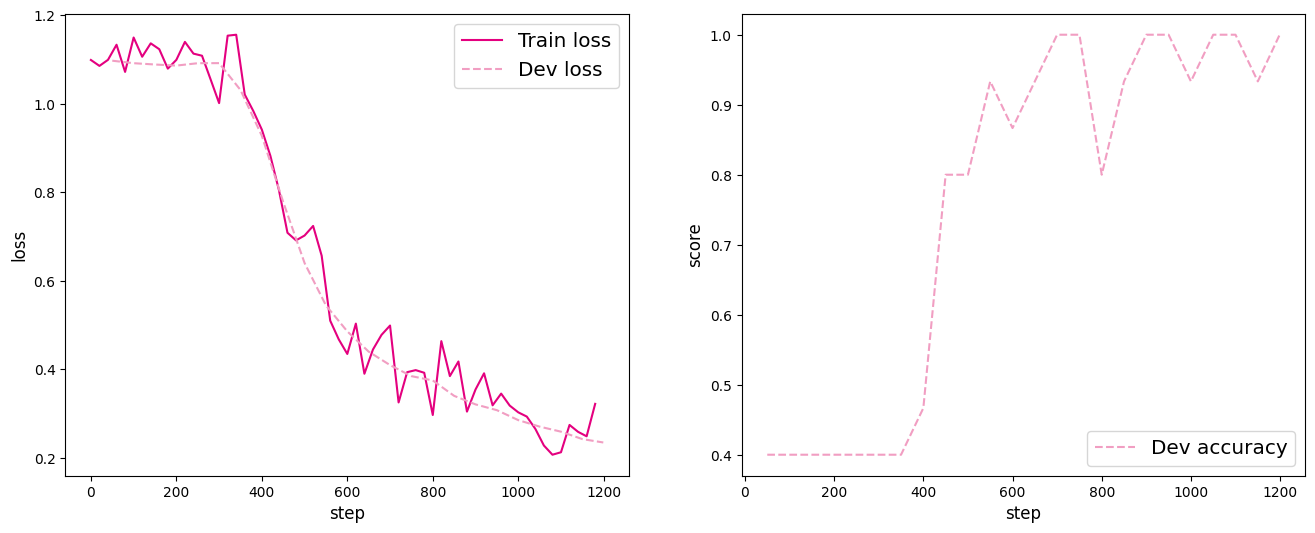

In [10]:
import matplotlib.pyplot as plt

# 绘制训练集和验证集的损失变化以及验证集上的准确率变化曲线
def plot_training_loss_acc(runner, fig_name, 
    fig_size=(16, 6), 
    sample_step=20, 
    loss_legend_loc="upper right", 
    acc_legend_loc="lower right",
    train_color="#e4007f",
    dev_color='#f19ec2',
    fontsize='large',
    train_linestyle="-",
    dev_linestyle='--'):

    plt.figure(figsize=fig_size)

    plt.subplot(1,2,1)
    train_items = runner.train_step_losses[::sample_step]
    train_steps=[x[0] for x in train_items]
    train_losses = [x[1] for x in train_items]

    plt.plot(train_steps, train_losses, color=train_color, linestyle=train_linestyle, label="Train loss")
    if len(runner.dev_losses)>0:
        dev_steps=[x[0] for x in runner.dev_losses]
        dev_losses = [x[1] for x in runner.dev_losses]
        plt.plot(dev_steps, dev_losses, color=dev_color, linestyle=dev_linestyle, label="Dev loss")
    # 绘制坐标轴和图例
    plt.ylabel("loss", fontsize=fontsize)
    plt.xlabel("step", fontsize=fontsize)
    plt.legend(loc=loss_legend_loc, fontsize='x-large')

    # 绘制评价准确率变化曲线
    if len(runner.dev_scores)>0:
        plt.subplot(1,2,2)
        plt.plot(dev_steps, runner.dev_scores,
            color=dev_color, linestyle=dev_linestyle, label="Dev accuracy")
    
        # 绘制坐标轴和图例
        plt.ylabel("score", fontsize=fontsize)
        plt.xlabel("step", fontsize=fontsize)
        plt.legend(loc=acc_legend_loc, fontsize='x-large')

    plt.savefig(fig_name)
    plt.show()

plot_training_loss_acc(runner, 'fw-loss.pdf')

从输出结果可以看出准确率随着迭代次数增加逐渐上升，损失函数下降。

### 1.5.6 模型评价

使用测试数据对在训练过程中保存的最佳模型进行评价，观察模型在测试集上的准确率以及Loss情况。代码实现如下：

In [11]:
# 加载最优模型
runner.load_model('best_model.pdparams')
# 模型评价
score, loss = runner.evaluate(test_loader)
print("[Test] accuracy/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] accuracy/loss: 0.8000/0.5060


I1226 16:17:12.665455  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.


### 1.5.7 模型预测

同样地，也可以使用保存好的模型，对测试集中的某一个数据进行模型预测，观察模型效果。代码实现如下：

In [12]:
# 获取测试集中第一条数据
X, label = next(test_loader())
logits = runner.predict(X)

pred_class = paddle.argmax(logits[0]).numpy()
label = label[0][0].numpy()

# 输出真实类别与预测类别
print("The true category is {} and the predicted category is {}".format(label, pred_class))

The true category is [2] and the predicted category is [2]


I1226 16:17:15.852708  1726 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.


## 1.6 小结

本次作业介绍了前馈神经网络的基本概念、网络结构及代码实现，利用前馈神经网络完成一个分类任务，并通过两个简单的实验，观察前馈神经网络的梯度消失问题和死亡ReLU问题，以及对应的优化策略。
此外，还实践了基于前馈神经网络完成鸢尾花分类任务。